## Overland Flow Scratchwork

First get the necessary libraries

In [1]:
import numpy as np
from matplotlib.pyplot import figure

from landlab.components import OverlandFlow

from landlab.io.esri_ascii import read_esri_ascii
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

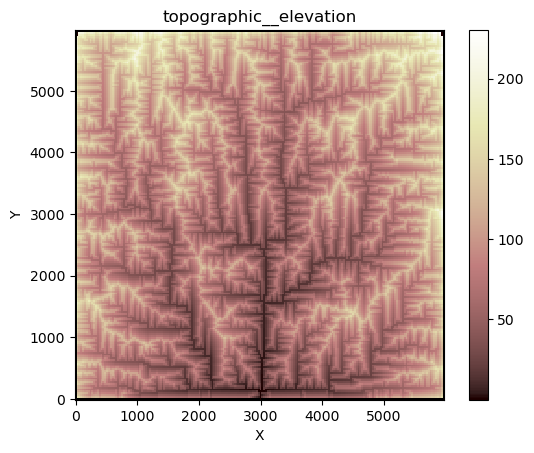

In [2]:
#read in artificially generated raster
grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

#close all boundaries
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

#open the outlet 
#This DEM was generated using Landlab and the outlet node ID was known
my_outlet_node = 100
grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

In [3]:
#add surface water depth (1 m everywhere)
grid.add_ones("surface_water__depth", at = "node", clobber = True)



array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

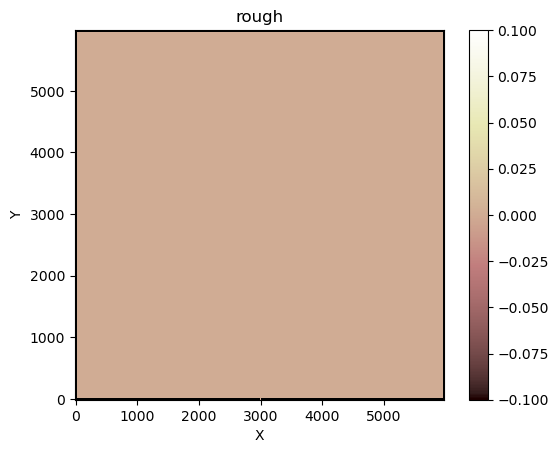

In [4]:
#now add rouughness
grid.add_zeros("rough",  at = "node", clobber=True)

#create some variation
grid.at_node["rough"][6] = 0.02

#plot roughness
figure('mannings_n')
imshow.imshow_grid_at_node(grid, "rough")

In [5]:
#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()


['mannings_n']

In [ ]:
def constantM(n):
    run_time = 100
    elapsed_time = 0.0
    grid1 = grid
    of = OverlandFlow(grid1, mannings_n = n, rainfall_intensity=2*(10**-6), steep_slopes=True)
    while elapsed_time <= run_time:
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow()

        elapsed_time += of.dt
    return grid1, elapsed_time # maybe we don't need to see the elapsed time


In [ ]:
def constantM(n):
    hydrograph_time = []
    discharge_at_outlet = []
    
    run_time = 500
    elapsed_time = 0.0
    grid1 = grid
    of = OverlandFlow(grid1, mannings_n = n, rainfall_intensity=2*(10**-6), steep_slopes=True)
    #q = grid1.at_link['surface_water__discharge']  # surface water defined at links https://landlab.readthedocs.io/en/master/reference/components/overland_flow.html
    while elapsed_time <= run_time:
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow()
        q = grid1.at_link['surface_water__discharge']
        grid1.at_node['surface_water__discharge'] = of.discharge_mapper(q, convert_to_volume=True) # fix this

        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(q[100]) * grid1.dx) # append discharge in m^3/s
        elapsed_time += of.dt
    return grid1, hydrograph_time, discharge_at_outlet, elapsed_time # maybe we don't need to see the elapsed time


In [ ]:
# not working 
time, discharge = constantM(0.02)[1:3] # https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html
plt.plot(time, discharge)
plt.ylabel('Time (hr)')
plt.xlabel('Discharge, (cms)')
plt.title('Outlet Hydrograph')

In [ ]:
print(constantM(0.02)[3])
grass_constant_m = constantM(n = 0.02)[0]
figure('water depth')
imshow.imshow_grid(grass_constant_m, "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth {Constant n}', # figure out how to change title
                          var_name = 'Water Depth (m)')


In [ ]:
#using new calc
def newOverlandFlow(den, diam, height):
    run_time = 400
    elapsed_time = 0.0
    grid2 = grid
    of = OverlandFlow(grid2, 
                      rainfall_intensity=1*(10**-6), 
                      steep_slopes=True)
    while elapsed_time <= run_time:
        new_manning = []
        for depth in grid2.at_link["surface_water__depth"]:
            flow_resistance = FlowResistance()
        #water_depth = 10 # this shall be updtaed with time
            cr = flow_resistance.Baptist_2007(bed_roughness=10, 
                                              drag_coef=1.0, 
                                              veg_den=den, 
                                              veg_diam=diam, 
                                              veg_height=height, 
                                              gravity=9.81, 
                                              van_karman=0.41, 
                                              water_depth=depth)
        
            n=flow_resistance.chezy_to_manning(depth,cr)
           # print(elapsed_time, n, depth)
            #print(n)
            new_manning.append(n)
        
        #of = OverlandFlow(grid, mannings_n = new_manning, rainfall_intensity=1*(10**-6), steep_slopes=True)
        grid2.add_field("mannings_n", new_manning, at = "link", clobber=True)
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow()
        elapsed_time += of.dt
    return grid2, elapsed_time # maybe we don't need to see the elapsed time
  


In [ ]:
# calculate the roughness for different vegetation

# Veg 1 - grassland
# varrying n
print(newOverlandFlow(den = 4500, diam = 0.003, height = 0.15)[1])
grass_varying_n = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15)[0]
#figure('water depth')
imshow.imshow_grid(grass_varying_n,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth - Grassland', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')
#print(len(new_manning))
#print(grid.number_of_links)
#print(elapsed_time)

In [ ]:
# side by side plots
import matplotlib.transforms as mtransforms

fig2 = imshow.imshow_grid(grass_constant_m, "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth {Constant n}', # figure out how to change title
                          var_name = 'Water Depth (m)')
plt.savefig('fig1.png', format='png')


#fig2 = imshow.imshow_grid(grass_varying_n, "surface_water__depth", 
                           #cmap = 'Blues', 
                           #plot_name = 'Surface Water Depth {Constant n}', # figure out how to change title
                          #var_name = 'Water Depth (m)')
#plt.savefig('fig2.png', format='png')


In [ ]:
import matplotlib.transforms as mtransforms
fig3, ax3 = plt.subplots(nrows=1, ncols=2)
ax3[0].imshow(fig1.canvas.renderer.buffer_rgba())
ax3[1].imshow(fig2.canvas.renderer.buffer_rgba())
ax3[0].axis('off')
ax3[1].axis('off')

In [ ]:
# Veg 2 - trees
updated_grid = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15)
#figure('water depth')
imshow.imshow_grid(updated_grid,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth Trees', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')